In [1]:
from immune_functions import *
from matplotlib.backends import backend_pdf as bpdf
import pickle

# Look at cross-reactivity networks

## High-dimensional

(100, 1000)
(100, 100)
(100,)


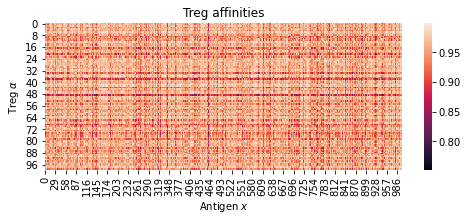

56


/Users/robertmarsland/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


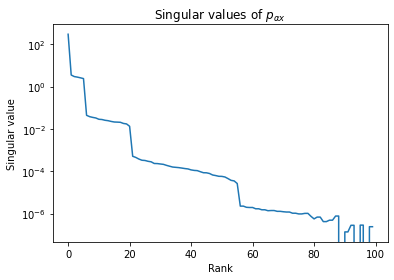

In [2]:
params = {}
params['sampling'] = 'Multidimensional'
params['Num_treg'] = 100
params['Num_tcell'] = 100
params['Num_sites'] = 1000
params['c'] = 1
params['max_v'] = 1
params['shape_dim'] = 5
params['sigma'] = 10
pix,palphax = MakeAffinities(params)
vx = np.ones(params['Num_sites'])
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
print(np.shape(pix))
print(np.shape(phi_cell_reg))
print(np.shape(rvals))

fig,ax=plt.subplots(figsize=(8,3))
fig.subplots_adjust(bottom=0.2)
sns.heatmap(palphax,ax=ax)
ax.set_title('Treg affinities')
ax.set_xlabel(r'Antigen $x$')
ax.set_ylabel(r'Treg $\alpha$')
plt.savefig('../figures/treg_multi.png')
plt.show()

thresh=1e-5
vx = np.ones(params['Num_sites'])
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
lam,u = np.linalg.eig(phi_reg_reg)
alpha= params['Num_treg']/((np.sqrt(np.abs(lam))>thresh).sum())
print((np.sqrt(np.abs(lam))>thresh).sum())

lam = np.sort(lam)[::-1]
plt.semilogy(np.sqrt(lam))
plt.gca().set_xlabel('Rank')
plt.gca().set_ylabel('Singular value')
plt.gca().set_title(r'Singular values of $p_{\alpha x}$')
plt.show()

## i.i.d. and one-dimensional

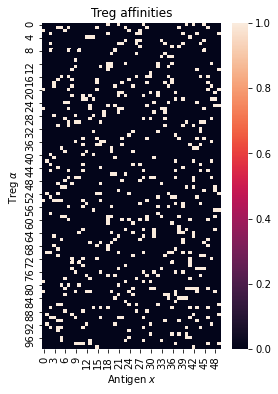

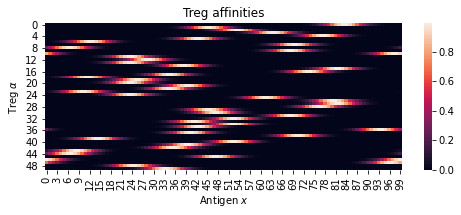

In [4]:
# Parameters
params = {}
params['sampling'] = 'Binary'
params['Num_treg'] = 100
params['Num_tcell'] = 100
params['Num_sites'] = 50
params['pval_cell'] = 0.1
params['pval_treg'] = 0.1
params['c'] = 1
params['sigma_cp'] = 0

# Make affinities and plot
pix, palphax = MakeAffinities(params)
fig,ax=plt.subplots(figsize=(4,6))
sns.heatmap(palphax,ax=ax)
ax.set_title('Treg affinities')
ax.set_xlabel(r'Antigen $x$')
ax.set_ylabel(r'Treg $\alpha$')
pdf = bpdf.PdfPages('../figures/treg_binary.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

params['sampling'] = '1D'
params['Num_sites'] = 100
params['Num_treg'] = 50
params['niche_width'] = 2*params['Num_sites']/params['Num_treg']

# Make affinities and plot
pix, palphax = MakeAffinities(params)
fig,ax=plt.subplots(figsize=(8,3))
fig.subplots_adjust(bottom=0.2)
sns.heatmap(palphax,ax=ax)
ax.set_title('Treg affinities')
ax.set_xlabel(r'Antigen $x$')
ax.set_ylabel(r'Treg $\alpha$')
pdf = bpdf.PdfPages('../figures/treg_gauss.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Full model

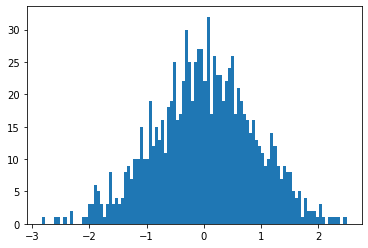

In [150]:
y0 = np.random.lognormal(mean=0,sigma=2,size=1000)
plt.hist(np.log10(y0),bins=100)
#plt.gca().set_xscale('log')
plt.show()

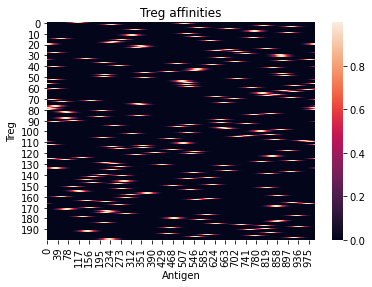

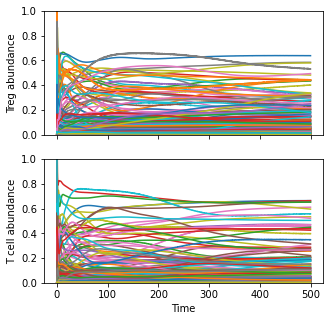

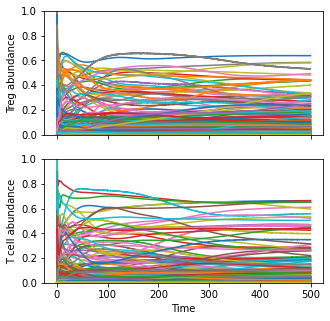

In [13]:
# Parameters
t0 = 0
tf = 500
params = {}
params['sampling'] = '1D'
params['Num_treg'] = 200
params['Num_tcell'] = 200
params['Num_sites'] = 1000
params['c'] = 1
params['max_v'] = 1
params['niche_width'] = 4*params['Num_sites']/params['Num_treg']
#y0 = np.ones(params['Num_treg']+params['Num_tcell'])*0.01
y0 = np.random.lognormal(mean=0,sigma=2,size=params['Num_treg']+params['Num_tcell'])*.01

# Make affinities and plot
pix, palphax = MakeAffinities(params)
sns.heatmap(palphax)
plt.gca().set_title('Treg affinities')
plt.gca().set_xlabel('Antigen')
plt.gca().set_ylabel('Treg')
plt.show()

#Make antigen concentrations
vx = np.random.rand(params['Num_sites'])

#Make overlaps and train
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)

out = solve_ivp(lambda t,y: ddt_simple(t,y,phi_reg_reg,phi_cell_reg,rvals),(t0,tf),y0)
Tcell_approx = out.y[:params['Num_tcell'],:].T
Treg_approx = out.y[params['Num_tcell']:,:].T
t = out.t
fig,ax=plt.subplots(2,sharex=True,figsize=(5,5))
#fig.subplots_adjust(left=0.2)
ax[0].plot(t,Treg_approx)
ax[0].set_ylabel('Treg abundance')
ax[1].plot(t,Tcell_approx)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('T cell abundance')
ax[1].set_ylim((0,1))
ax[0].set_ylim((0,1))
pdf = bpdf.PdfPages('../figures/dynamics_approx.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

out = solve_ivp(lambda t,y: ddt_full(t,y,pix,palphax,vx),(t0,tf),y0,t_eval=t)
Tcell_exact = out.y[:params['Num_tcell'],:].T
Treg_exact = out.y[params['Num_tcell']:,:].T
t = out.t
fig,ax=plt.subplots(2,sharex=True,figsize=(5,5))
#fig.subplots_adjust(left=0.2)
ax[0].plot(t,Treg_exact)
ax[0].set_ylabel('Treg abundance')
ax[1].plot(t,Tcell_exact)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('T cell abundance')
ax[1].set_ylim((0,1))
ax[0].set_ylim((0,1))
pdf = bpdf.PdfPages('../figures/dynamics_exact.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

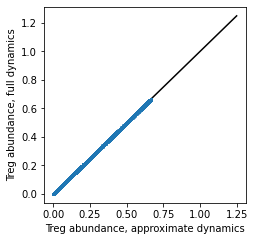

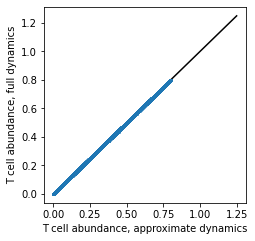

In [16]:
fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.2,bottom=0.2)
ax.plot([0.01,1.25],[0.01,1.25],'k')
ax.plot(Treg_approx[100:,].reshape(-1),Treg_exact[100:,].reshape(-1),'o',ms=2)
ax.set_xlabel('Treg abundance, approximate dynamics')
ax.set_ylabel('Treg abundance, full dynamics')
plt.savefig('../figures/treg_compare.png')
plt.show()

fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.2,bottom=0.2)
ax.plot([0.01,1.25],[0.01,1.25],'k')
ax.plot(Tcell_approx[100:,].reshape(-1),Tcell_exact[100:,].reshape(-1),'o',ms=2)
ax.set_xlabel('T cell abundance, approximate dynamics')
ax.set_ylabel('T cell abundance, full dynamics')
plt.savefig('../figures/tcell_compare.png')
plt.show()

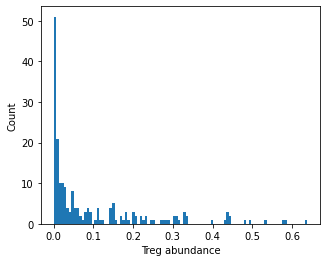

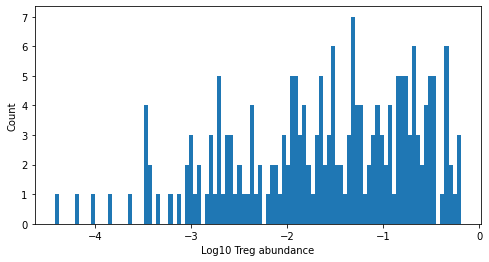

In [15]:
fig,ax=plt.subplots(figsize=(5,4))
ax.hist(Treg_exact[-1,:],bins=100)
ax.set_xlabel('Treg abundance')
ax.set_ylabel('Count')
pdf = bpdf.PdfPages('../figures/treg_dist.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

fig,ax=plt.subplots(figsize=(8,4))
ax.hist(np.log10(Treg_exact[-1,:]),bins=100)
ax.set_xlabel('Log10 Treg abundance')
ax.set_ylabel('Count')
pdf = bpdf.PdfPages('../figures/treg_dist_log.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

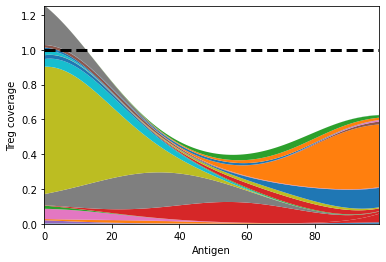

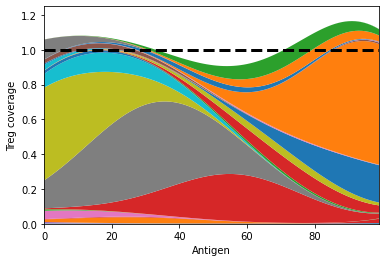

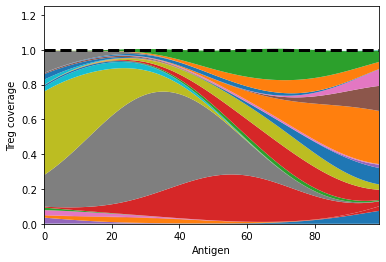

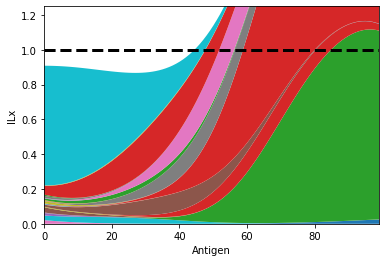

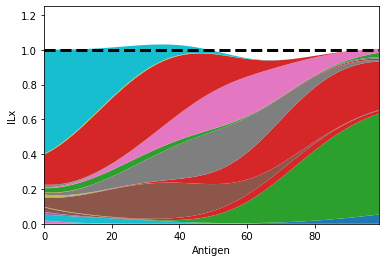

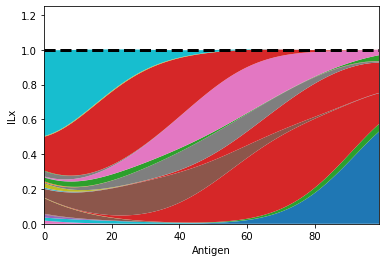

In [24]:
#Plot Treg coverage
times = [8,18,-1]
for time in times:
    coverage = palphax.T*Treg_exact[time]
    fig,ax = plt.subplots()
    ax.stackplot(np.arange(len(vx)),coverage.T)
    ax.plot([0,99],[1,1],'k--',lw=3)
    ax.set_ylim((0,1.25))
    ax.set_xlim((0,99))
    ax.set_xlabel('Antigen')
    ax.set_ylabel('Treg coverage')
    plt.show()
    
#Plot IL coverage
times = [8,18,-1]
for time in times:
    coverage = (pix.T*Tcell_exact[time]).T/(palphax.T.dot(Treg_exact[time]))
    fig,ax = plt.subplots()
    ax.stackplot(np.arange(len(vx)),coverage)
    ax.plot([0,99],[1,1],'k--',lw=3)
    ax.set_ylim((0,1.25))
    ax.set_xlim((0,99))
    ax.set_xlabel('Antigen')
    ax.set_ylabel('ILx')
    plt.show()

## Simulate with changing $v_x$

In [7]:
def ddt_fluct(t,y,pix,palphax,vx0,omega):
    vx = vx0*(np.sin(omega*t)**2)
    Num_treg = len(palphax)
    Num_tcell = len(pix)
    Tcell = y[:Num_tcell]
    Treg = y[Num_tcell:]

    Qx = palphax.T.dot(Treg)
    ILx = (pix.T.dot(Tcell))/(palphax.T.dot(Treg))
    
    dTcelldt = Tcell*pix.dot(vx*(1-Qx))
    dTregdt = Treg*palphax.dot(vx*(ILx-1))
    
    return np.hstack((dTcelldt, dTregdt))

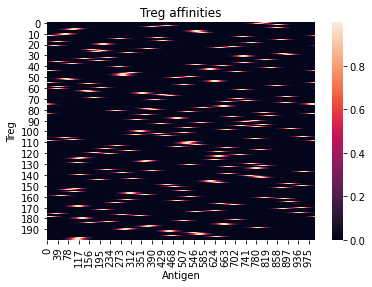

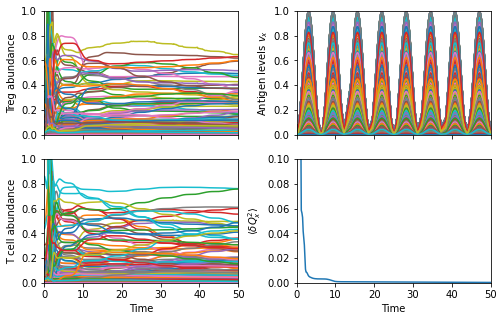

In [23]:
# Parameters
t0 = 0
tf = 50
omega = .5
params = {}
params['sampling'] = '1D'
params['Num_treg'] = 200
params['Num_tcell'] = 200
params['Num_sites'] = 1000
params['c'] = 1
params['max_v'] = 1
params['niche_width'] = 4*params['Num_sites']/params['Num_treg']
#y0 = np.ones(params['Num_treg']+params['Num_tcell'])*0.01
y0 = np.random.lognormal(mean=0,sigma=2,size=params['Num_treg']+params['Num_tcell'])*.01

# Make affinities and plot
pix, palphax = MakeAffinities(params)
sns.heatmap(palphax)
plt.gca().set_title('Treg affinities')
plt.gca().set_xlabel('Antigen')
plt.gca().set_ylabel('Treg')
plt.show()

#Make antigen concentrations
vx = np.random.rand(params['Num_sites'])

#Make overlaps and train
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)

out = solve_ivp(lambda t,y: ddt_fluct(t,y,pix,palphax,vx,omega),(t0,tf),y0)
Tcell_exact = out.y[:params['Num_tcell'],:].T
Treg_exact = out.y[params['Num_tcell']:,:].T
Qx = ((1-palphax.T.dot(Treg_exact.T))**2).mean(axis=0)
t = out.t
fig,ax=plt.subplots(2,2,sharex=True,figsize=(8,5))
fig.subplots_adjust(wspace=0.3)
ax[0,0].plot(t,Treg_exact)
ax[0,0].set_ylabel('Treg abundance')
ax[1,0].plot(t,Tcell_exact)
ax[1,0].set_xlabel('Time')
ax[1,1].set_xlabel('Time')
ax[1,0].set_ylabel('T cell abundance')
ax[0,1].plot(t,(np.sin(omega*t[:,np.newaxis])**2)*vx[np.newaxis,:])
ax[0,1].set_ylabel(r'Antigen levels $v_x$')
ax[1,1].plot(t,Qx)
ax[1,1].set_ylim((0,.1))
ax[1,1].set_ylabel(r'$\langle \delta Q_x^2\rangle$')
ax[0,1].set_ylim((0,1))
ax[0,0].set_ylim((0,1))
ax[1,0].set_ylim((0,1))
ax[0,0].set_xlim((0,tf))
pdf = bpdf.PdfPages('../figures/dynamics_fluct.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

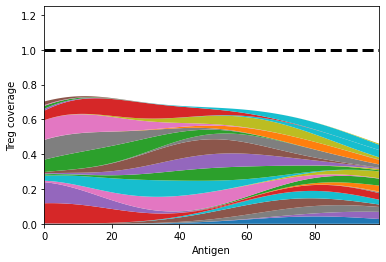

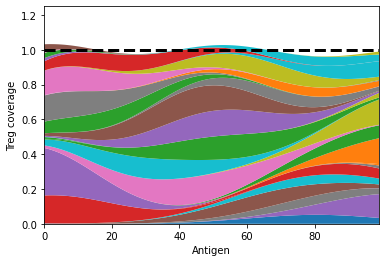

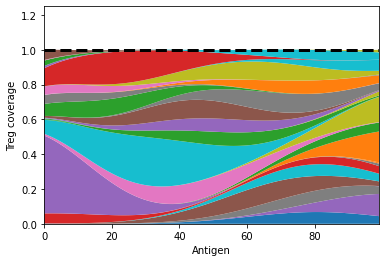

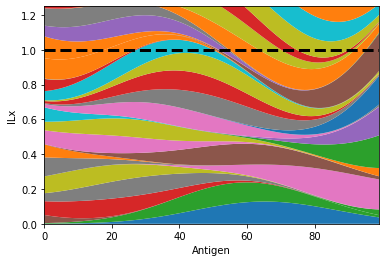

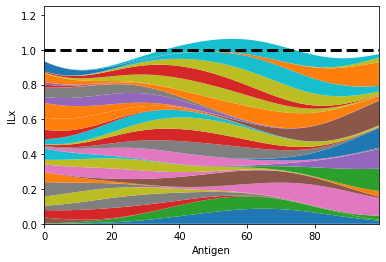

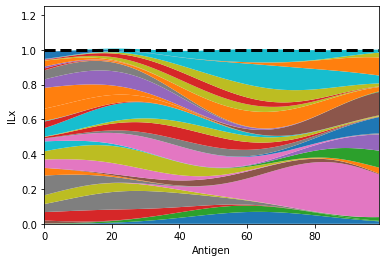

In [9]:
#Plot Treg coverage
times = [8,18,-1]
for time in times:
    coverage = palphax.T*Treg_exact[time]
    fig,ax = plt.subplots()
    ax.stackplot(np.arange(len(vx)),coverage.T)
    ax.plot([0,99],[1,1],'k--',lw=3)
    ax.set_ylim((0,1.25))
    ax.set_xlim((0,99))
    ax.set_xlabel('Antigen')
    ax.set_ylabel('Treg coverage')
    plt.show()

#Plot IL coverage
times = [8,18,-1]
for time in times:
    coverage = (pix.T*Tcell_exact[time]).T/(palphax.T.dot(Treg_exact[time]))
    fig,ax = plt.subplots()
    ax.stackplot(np.arange(len(vx)),coverage)
    ax.plot([0,99],[1,1],'k--',lw=3)
    ax.set_ylim((0,1.25))
    ax.set_xlim((0,99))
    ax.set_xlabel('Antigen')
    ax.set_ylabel('ILx')
    plt.show()

# Phase transition

## Binary, i.i.d.

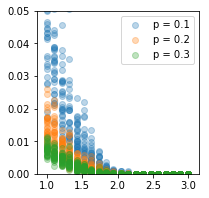

In [11]:
fig,ax=plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.15)
sensitivity = pd.read_csv('../data/sensitivity_binary.csv',index_col=0)
for p,data in sensitivity.groupby('p'):
    ax.scatter(data['alpha'].values,data['Qvar'].values,label='p = '+str(p),alpha=0.3)
plt.legend()
ax.set_ylim((0,.05))
pdf = bpdf.PdfPages('../figures/sense_binary.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

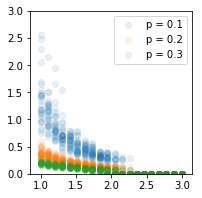

In [25]:
fig,ax=plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.15)
sensitivity = pd.read_csv('../data/sensitivity_binary.csv',index_col=0)
for p,data in sensitivity.groupby('p'):
    ax.scatter(data['alpha'].values,data['ILvar'].values,label='p = '+str(p),alpha=0.1)
plt.legend()
ax.set_ylim((0,3))
pdf = bpdf.PdfPages('../figures/sense_binary_IL.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## 1D niche axis

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


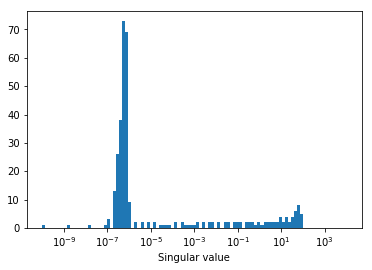

In [12]:
with open('../data/spectra.dat','rb') as f:
    spectrum = pickle.load(f)

k=-10 #index of the run to examine
plt.hist(np.sqrt(np.real(spectrum[k])),bins=np.logspace(-10,4,100))
plt.gca().set_xscale('log')
plt.gca().set_xlabel('Singular value')
plt.show()

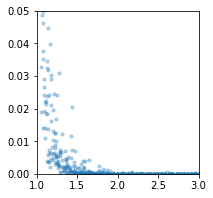

In [13]:
sensitivity = pd.read_csv('../data/sensitivity_1D.csv',index_col=0)
thresh=1e-6
Nreff = []
for item in sensitivity.index:
    Nreff.append((np.sqrt(np.abs(spectrum[item]))>thresh).sum())
    sensitivity.loc[item,'alpha'] = 500/Nreff[-1]
    
fig,ax=plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.15)
ax.scatter(sensitivity['alpha'].values,np.array(sensitivity['Qvar'].values),s=10,alpha=0.3)
#plt.gca().set_xlabel(r'Number of Tregs/Rank of $p_{\alpha x}$')
#plt.gca().set_ylabel(r'Sensitivity $\langle (\partial g_i/\partial v_x)^2\rangle$')
ax.set_ylim((0,0.05))
ax.set_xlim((1,3))
pdf = bpdf.PdfPages('../figures/sense_1D.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

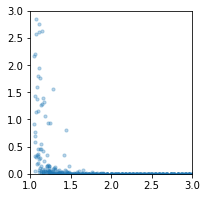

In [14]:
sensitivity = pd.read_csv('../data/sensitivity_1D.csv',index_col=0)
thresh=1e-6
Nreff = []
for item in sensitivity.index:
    Nreff.append((np.sqrt(np.abs(spectrum[item]))>thresh).sum())
    sensitivity.loc[item,'alpha'] = 500/Nreff[-1]
    
fig,ax=plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.15)
ax.scatter(sensitivity['alpha'].values,np.array(sensitivity['ILvar'].values),s=10,alpha=0.3)
#plt.gca().set_xlabel(r'Number of Tregs/Rank of $p_{\alpha x}$')
#plt.gca().set_ylabel(r'Sensitivity $\langle (\partial g_i/\partial v_x)^2\rangle$')
ax.set_ylim((0,3))
ax.set_xlim((1,3))
pdf = bpdf.PdfPages('../figures/sense_1D_IL.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Five dimensions

<ipython-input-9-496d4dec4fb0>:5: RuntimeWarning: invalid value encountered in sqrt
  plt.hist(np.sqrt(np.real(spectrum[k])),bins=np.logspace(-10,4,100))


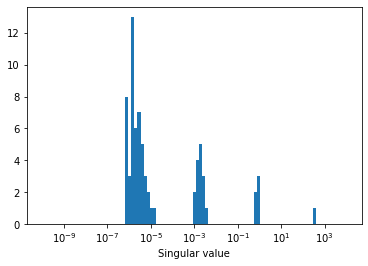

In [9]:
with open('../data/spectra.dat','rb') as f:
    spectrum = pickle.load(f)

k=-10 #index of the run to examine
plt.hist(np.sqrt(np.real(spectrum[k])),bins=np.logspace(-10,4,100))
plt.gca().set_xscale('log')
plt.gca().set_xlabel('Singular value')
plt.show()

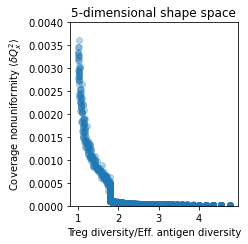

In [5]:
fig,ax=plt.subplots(figsize=(3.5,3.5))
#fig.subplots_adjust(left=0.25)
#fig.subplots_adjust(left=0.25)
sensitivity = pd.read_csv('../data/sensitivity_multi_3.csv',index_col=0)
ax.scatter(sensitivity['alpha'].values,sensitivity['Qvar'].values,alpha=0.3)
ax.set_ylim((0,.004))
ax.set_xlabel('Treg diversity/Eff. antigen diversity')
ax.set_ylabel(r'Coverage nonuniformity $\langle \delta Q_x^2\rangle$')
ax.set_title('5-dimensional shape space')
plt.tight_layout()
pdf = bpdf.PdfPages('../figures/sense_multi.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

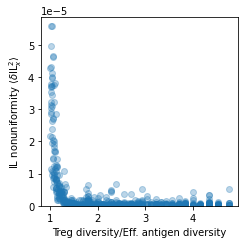

In [8]:
fig,ax=plt.subplots(figsize=(3.5,3.5))
#fig.subplots_adjust(left=0.25)
#fig.subplots_adjust(left=0.25)
sensitivity = pd.read_csv('../data/sensitivity_multi_3.csv',index_col=0)
ax.scatter(sensitivity['alpha'].values,sensitivity['ILvar'].values,alpha=0.3)
#ax.set_ylim((0,.01))
ax.set_ylim((0,None))
ax.set_xlabel('Treg diversity/Eff. antigen diversity')
ax.set_ylabel(r'IL nonuniformity $\langle \delta {\rm IL}_x^2\rangle$')
#ax.set_title('5-dimensional shape space')
plt.tight_layout()
pdf = bpdf.PdfPages('../figures/sense_multi_IL.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Pathogen response, allergies, persistent infection

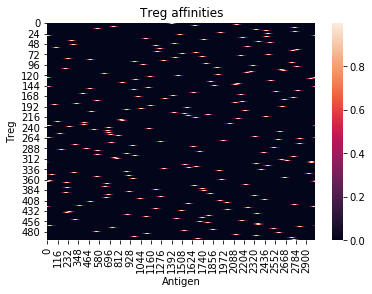

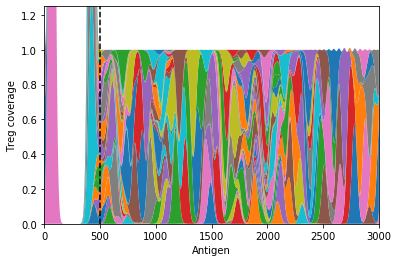

In [180]:
# Parameters
Num_path = 500
reg_thresh = 1e-2
cell_thresh = 1e-4
params = {}
params['sampling'] = '1D'
params['Num_treg'] = 500
params['Num_tcell'] = 5000
params['Num_sites'] = 3000
params['c'] = 1
params['max_v'] = 1
params['niche_width'] = 4*params['Num_sites']/params['Num_treg']

# Make affinities and plot
pix, palphax = MakeAffinities(params)
sns.heatmap(palphax)
plt.gca().set_title('Treg affinities')
plt.gca().set_xlabel('Antigen')
plt.gca().set_ylabel('Treg')
plt.show()

#Make antigen concentrations
vx = (params['max_v']/2)*np.ones(params['Num_sites'])
vx[:Num_path] = 0

#Positive selection:
palphax = palphax[palphax.dot(vx)>reg_thresh]
pix = pix[pix.dot(vx)>cell_thresh]

#Make overlaps and train
#palphax = palphax*(1+np.random.randn(params['Num_treg'],params['Num_sites'])*0.01)
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)

#Plot Treg coverage
coverage = palphax.T*Treg
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([Num_path,Num_path],[0,1.25],'k--')
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel('Antigen')
ax.set_ylabel('Treg coverage')
plt.show()


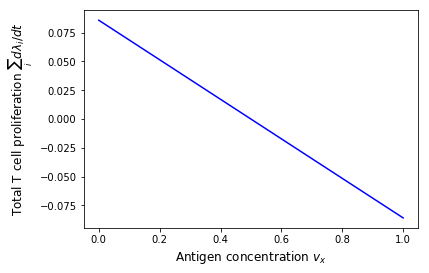

In [33]:
#Plot response for self antigen
dTcellxdt = ((pix*(1-palphax.T.dot(Treg))).T*Tcell).sum(axis=1)
vx_axis = np.linspace(0,1,5)
vx_new = np.array([vx.copy() for k in range(len(vx_axis))]).T
vx_new[xnormal,:] = vx_axis
fig,ax = plt.subplots()
ax.plot(vx_axis,dTcellxdt.dot(vx_new),color=colors[xnormal])
#ax.plot([0,1],[0,0],'k',lw=2)
ax.set_xlabel(r'Antigen concentration $v_x$',fontsize=12)
ax.set_ylabel(r'Total T cell proliferation $\sum_i d\lambda_i/dt$',fontsize=12)
#ax.set_ylim((-1,1))
plt.show()

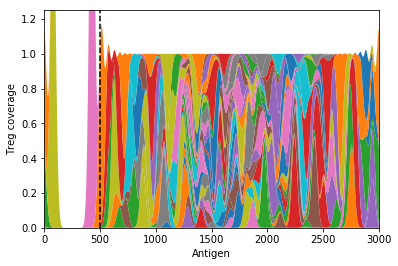

In [32]:
#Re-train with all antigens present
vx = (params['max_v']/2)*np.ones(params['Num_sites'])
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)

#Plot Treg coverage
coverage = palphax.T*Treg
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([Num_path,Num_path],[0,1.25],'k--')
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel('Antigen')
ax.set_ylabel('Treg coverage')
plt.show()

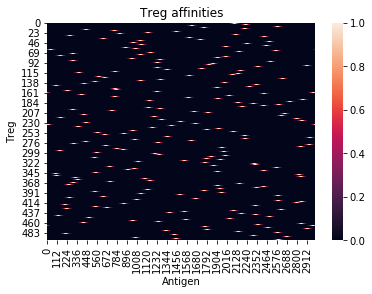

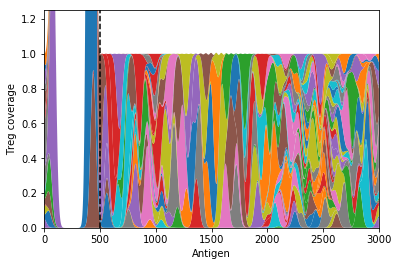

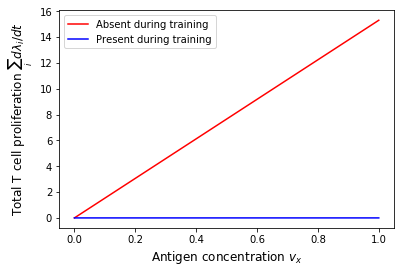

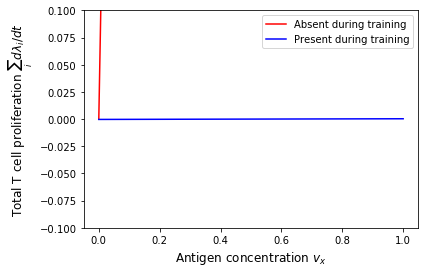

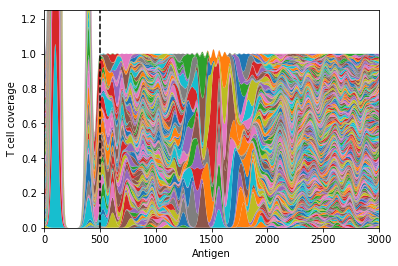

----------------Train to persistent infection--------------------


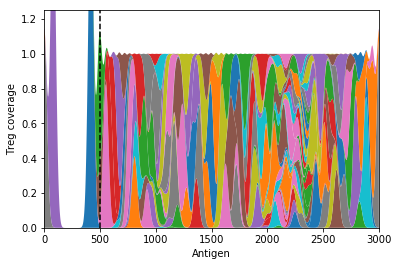

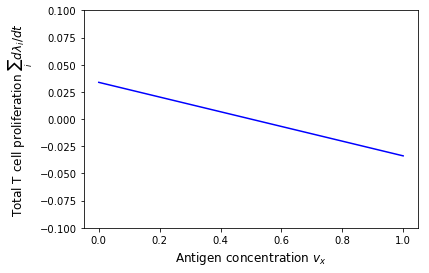

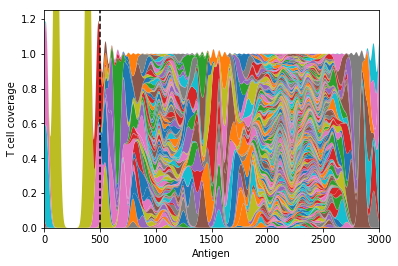

In [34]:
# Parameters
Num_path = 500
reg_thresh = 1e-2
cell_thresh = 1e-4
params = {}
params['sampling'] = '1D'
params['Num_treg'] = 500
params['Num_tcell'] = 5000
params['Num_sites'] = 3000
params['c'] = 1
params['max_v'] = 1
params['niche_width'] = 4*params['Num_sites']/params['Num_treg']

# Make affinities and plot
pix, palphax = MakeAffinities(params)
sns.heatmap(palphax)
plt.gca().set_title('Treg affinities')
plt.gca().set_xlabel('Antigen')
plt.gca().set_ylabel('Treg')
plt.show()

#Make antigen concentrations
vx = (params['max_v']/2)*np.ones(params['Num_sites'])
vx[:Num_path] = 0

#Positive selection:
palphax = palphax[palphax.dot(vx)>reg_thresh]
pix = pix[pix.dot(vx)>cell_thresh]

#Make overlaps and train
#palphax = palphax*(1+np.random.randn(params['Num_treg'],params['Num_sites'])*0.01)
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)

#Plot Treg coverage
coverage = palphax.T*Treg
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([Num_path,Num_path],[0,1.25],'k--')
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel('Antigen')
ax.set_ylabel('Treg coverage')
plt.show()

#Plot response for two antigens
colorlist = np.asarray(['b','r'])
colors = colorlist[np.asarray(vx==0,dtype=int)]
dTcellxdt = ((pix*(1-palphax.T.dot(Treg))).T*Tcell).sum(axis=1)
vx_axis = np.linspace(0,1,5)

xmin = np.argmax(dTcellxdt)
xnormal = 510
fig,ax = plt.subplots()
for x in [xmin,xnormal]:
    vx_new = np.array([vx.copy() for k in range(len(vx_axis))]).T
    vx_new[x,:] = vx_axis
    ax.plot(vx_axis,dTcellxdt.dot(vx_new),color=colors[x])
ax.plot([0],[0],color=colorlist[1],label='Absent during training')
ax.plot([0],[0],color=colorlist[0],label='Present during training')
#ax.plot([0,1],[0,0],'k',lw=2)
ax.set_xlabel(r'Antigen concentration $v_x$',fontsize=12)
ax.set_ylabel(r'Total T cell proliferation $\sum_i d\lambda_i/dt$',fontsize=12)
#ax.set_ylim((-1,1))
plt.legend()
plt.show()
fig,ax = plt.subplots()
for x in [xmin,xnormal]:
    vx_new = np.array([vx.copy() for k in range(len(vx_axis))]).T
    vx_new[x,:] = vx_axis
    ax.plot(vx_axis,dTcellxdt.dot(vx_new),color=colors[x])
ax.plot([0],[0],color=colorlist[1],label='Absent during training')
ax.plot([0],[0],color=colorlist[0],label='Present during training')
#ax.plot([0,1],[0,0],'k',lw=2)
ax.set_xlabel(r'Antigen concentration $v_x$',fontsize=12)
ax.set_ylabel(r'Total T cell proliferation $\sum_i d\lambda_i/dt$',fontsize=12)
ax.set_ylim((-.1,.1))
plt.legend()
plt.show()

#Plot T cell coverage
coverage = pix.T*Tcell
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([Num_path,Num_path],[0,1.25],'k--')
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel('Antigen')
ax.set_ylabel('T cell coverage')
plt.show()

print('----------------Train to persistent infection--------------------')

#Re-train with all antigens present
vx = (params['max_v']/2)*np.ones(params['Num_sites'])
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)

#Plot Treg coverage
coverage = palphax.T*Treg
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([Num_path,Num_path],[0,1.25],'k--')
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel('Antigen')
ax.set_ylabel('Treg coverage')
plt.show()

#Plot response for self antigen
dTcellxdt = ((pix*(1-palphax.T.dot(Treg))).T*Tcell).sum(axis=1)
vx_axis = np.linspace(0,1,5)
vx_new = np.array([vx.copy() for k in range(len(vx_axis))]).T
vx_new[xnormal,:] = vx_axis
fig,ax = plt.subplots()
ax.plot(vx_axis,dTcellxdt.dot(vx_new),color=colors[xnormal])
#ax.plot([0,1],[0,0],'k',lw=2)
ax.set_xlabel(r'Antigen concentration $v_x$',fontsize=12)
ax.set_ylabel(r'Total T cell proliferation $\sum_i d\lambda_i/dt$',fontsize=12)
ax.set_ylim((-.1,.1))
plt.show()

#Plot T cell coverage
coverage = pix.T*Tcell
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([Num_path,Num_path],[0,1.25],'k--')
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel('Antigen')
ax.set_ylabel('T cell coverage')
plt.show()

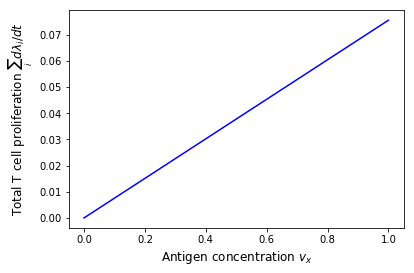

In [130]:
#Plot response for self antigen
dTcellxdt = ((pix*(1-palphax.T.dot(Treg))).T*Tcell).sum(axis=1)
xmin = np.argmax(dTcellxdt[Num_path:])+Num_path
vx_axis = np.linspace(0,1,5)
fig,ax = plt.subplots()
ax.plot(vx_axis,dTcellxdt[xmin]*vx_axis,color=colors[xnormal])
#ax.plot([0,1],[0,0],'k',lw=2)
ax.set_xlabel(r'Antigen concentration $v_x$',fontsize=12)
ax.set_ylabel(r'Total T cell proliferation $\sum_i d\lambda_i/dt$',fontsize=12)
#ax.set_ylim((-1,1))
plt.show()

# T cell population bottleneck

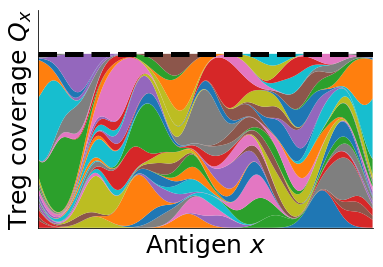

In [6]:
# Parameters
params = {}
params['sampling'] = '1D'
params['Num_treg'] = 100
params['Num_tcell'] = 1000
params['Num_sites'] = 800
params['c'] = 1
params['max_v'] = 1
params['niche_width'] = 4*params['Num_sites']/params['Num_treg']
pix, palphax = MakeAffinities(params)

#Make antigen concentrations
vx = np.ones(params['Num_sites'])

#Make overlaps and train
#palphax = palphax*(1+np.random.randn(params['Num_treg'],params['Num_sites'])*0.01)
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)

#Plot Treg coverage
coverage = palphax.T*Treg
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([0,len(vx)],[1,1],'k--',linewidth=5)
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel(r'Antigen $x$',fontsize=25)
ax.set_ylabel(r'Treg coverage $Q_x$',fontsize=25)
ax.set_xticks(())
ax.set_yticks(())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
pdf = bpdf.PdfPages('../figures/tiling.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

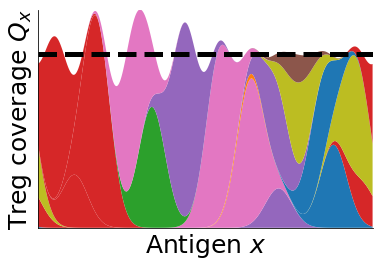

In [7]:
# Parameters
params = {}
params['sampling'] = '1D'
params['Num_treg'] = 50
params['Num_tcell'] = 1000
params['Num_sites'] = 800
params['c'] = 1
params['max_v'] = 1
params['niche_width'] = 4*params['Num_sites']/100
pix, palphax = MakeAffinities(params)

#Make antigen concentrations
vx = np.ones(params['Num_sites'])

#Make overlaps and train
#palphax = palphax*(1+np.random.randn(params['Num_treg'],params['Num_sites'])*0.01)
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)

#Plot Treg coverage
coverage = palphax.T*Treg
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([0,len(vx)],[1,1],'k--',linewidth=5)
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel(r'Antigen $x$',fontsize=25)
ax.set_ylabel(r'Treg coverage $Q_x$',fontsize=25)
ax.set_xticks(())
ax.set_yticks(())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
pdf = bpdf.PdfPages('../figures/tiling_imp.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()